In [161]:
import pickle
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

The MNIST database was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits. SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students.

The MNIST training set is composed of ``30 000`` patterns from SD-3 and ``30 000`` patterns from SD-1. The test set was composed of ``5 000`` patterns from SD-3 and ``5 000`` patterns from SD-1. The ``60 000`` pattern training set contained examples from approximately ``250`` writers. The writers of the training set and test set were disjoint.

The MNIST dataset contains images presented in efficient way in numpy ndarrays with ``28 * 28 = 784`` pixels in a single MNIST image. The dataset contains images of handwritten digits. So, the domain is 10 digits ``[0...9]``

In [162]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Downloading the MNIST data as a tuple containing the training data, the validation data, and the test data.

The ``tr_d`` is returned as a tuple with two entries.
The first entry contains the actual training images.  This is a numpy ndarray with 50,000 entries. 

The second entry in the ``tr_d`` tuple is a numpy ndarray containing 50,000 entries. Those entries are just the digit values ``[0...9]`` for the corresponding images contained in the first entry of the tuple.

The ``te_d`` is similar, except it contains only 10,000 images.

In [163]:
f = gzip.open('data/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
tr_d, va_d, te_d = u.load()
f.close()

For using in neural networks it's helpful to modify the format of the ``training_outputs``(labels) a little.

``Example:``
<br>
- ``input: 3``
<br>
- ``output: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]``

In [164]:
def vector_output(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

Reshaping into the format, which is more convenient for use in a neural network.

The ``training_data`` is a list containing 50,000 2-tuples ``(x, y)``. ``x`` is a 784-dimensional numpy.ndarray containing the input image. ``y`` is a 10-dimensional numpy.ndarray representing the unit vector corresponding to the correct digit for ``x``.

``test_data`` is a lists containing 10,000 2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional numpy.ndarry containing the input image, and ``y`` is the corresponding classification, i.e., the digit values (integers) corresponding to ``x``.

In [165]:
training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
training_outputs = [vector_output(y) for y in tr_d[1]]
training_data = list(zip(training_inputs, training_outputs))

test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
test_data = list(zip(test_inputs, te_d[1]))

Real format of data of, for example, the second "image" in the trining set.

In [166]:
print(np.reshape(tr_d[0][1], (28, 28)))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

Plotting the second image from the training dataset.
We can see this image is representing zero. 

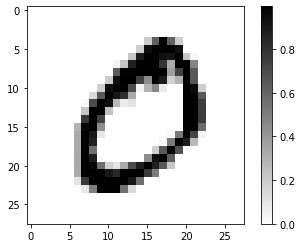

In [167]:
plt.figure()
plt.imshow(np.reshape(tr_d[0][1], (28, 28)), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

First ``25`` images from the training set and their labels

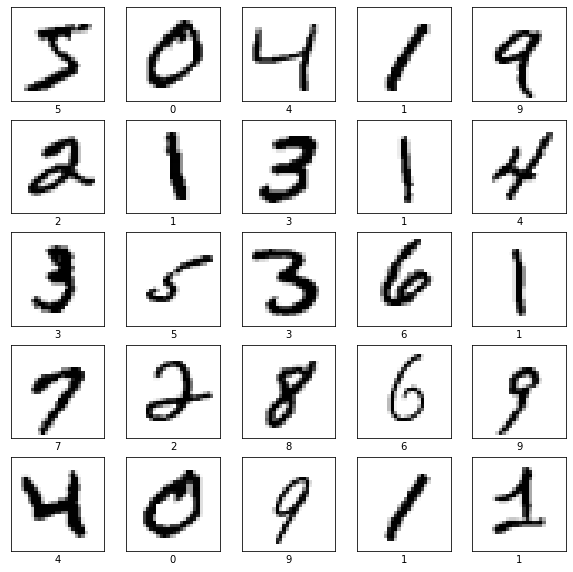

In [168]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(tr_d[0][i], (28, 28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[tr_d[1][i]])
    
plt.show()

Sigmoid activation function for normalization and it's derivative

In [169]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

#### Feed Forward Neural Network class

Learning method: stochastic gradient descent (randomly selected mini batches)
<br>
Accuracy evaluation - on the ``10 000`` size test set.
<br>
Constructor allows different combinations of topologies for the hidden layers.

In [170]:
class Network:

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = []
        for y in sizes[1:]:
            self.biases.append(np.random.randn(y, 1))
            #[30][1]  [10][1]

        self.weights = []
        for x, y in zip(sizes[:-1], sizes[1:]):
            self.weights.append(np.random.randn(y, x))
            #[784][30]  [30][10]

        # self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        # self.weights = [np.random.randn(y, x)
        #                 for x, y in zip(sizes[:-1], sizes[1:])]

    def feed_forward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def stochastic_gradient_descent(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        results = []
        if test_data:
            n_test = len(test_data)

        n = len(training_data)

        for j in range(epochs):
            random.shuffle(training_data)

            mini_batches = []
            for k in range(0, n, mini_batch_size):
                mini_batches.append(training_data[k:k + mini_batch_size])

            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            evaluation = self.evaluate(test_data)
            
            if test_data:
                print("Epoch {0} completed. Accuracy: {1} %".format(j, str(evaluation/100)))
                results.append(str(evaluation/100) + " %")
            else:
                print("Epoch {0} complete".format(j))
                
        return results

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.back_propagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

    def back_propagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        activations = [x]
        zs = [] 
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        delta = self.cost_derivative(activations[-1], y) * \
                sigmoid_prime(zs[-1])
        
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        # test_results = []
        # for (x, y) in test_data:
        #     test_results.append(np.argmax(self.feed_forward(x)), y)
        
        test_results = [(np.argmax(self.feed_forward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)


At the moment for testing the effectiveness of feed forward neural network I am using 2 topologies on the 5 epochs.
<br>
Each topology will have input layer contains 784 neurons(1 neuron for each "pixel").
<br>
Each topology will have output layer contains 10 neurons(1 neuron for each digit).

First topology:
- ``input layer: 784 neurons``
- ``hidden layer: 15 neurons``
- ``output layer: 10 neurons``
    
Second topology:
- ``input layer: 784 neurons``
- ``hidden layer: 30 neurons``
- ``output layer: 10 neurons``
    

In [171]:
print("1st network")
net1 = Network([784, 15, 10])
res1 = net1.stochastic_gradient_descent(training_data, 5, 10, 3.0, test_data=test_data)

print("2nd network")
net2 = Network([784, 30, 10])
res2 = net2.stochastic_gradient_descent(training_data, 5, 10, 3.0, test_data=test_data)

# net3 = = Network([784, 25, 15, 10])
# res2 = net2.stochastic_gradient_descent(training_data, 2, 10, 3.0, test_data=test_data)

1st network
Epoch 0 completed. Accuracy: 89.6 %
Epoch 1 completed. Accuracy: 91.07 %
Epoch 2 completed. Accuracy: 92.01 %
Epoch 3 completed. Accuracy: 92.08 %
Epoch 4 completed. Accuracy: 92.5 %
2nd network
Epoch 0 completed. Accuracy: 91.45 %
Epoch 1 completed. Accuracy: 92.65 %
Epoch 2 completed. Accuracy: 93.28 %
Epoch 3 completed. Accuracy: 93.54 %
Epoch 4 completed. Accuracy: 93.61 %


In [172]:
df = pd.DataFrame(list(zip(res1, res2)), columns = ["15 neurons in 1 hidden layer", "30 neurons in 1 hidden layer"])
df

,15 neurons in 1 hidden layer,30 neurons in 1 hidden layer
0,89.6 %,91.45 %
1,91.07 %,92.65 %
2,92.01 %,93.28 %
3,92.08 %,93.54 %
4,92.5 %,93.61 %
